In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import pandas as pd
import seaborn as sns
import datetime
import glob
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from matplotlib.pyplot import figure

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
files = glob.glob('/kaggle/input/airline-delay-and-cancellation-data-2009-2018/*.csv',recursive = True)
dfs = list()
for i, f in enumerate(files):
    if f=='/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2018.csv':
        continue
    data = pd.read_csv(f, usecols=['FL_DATE', 'DEP_DELAY', 'OP_CARRIER'])
#     data['file'] = f'File {i}'
    dfs.append(data)
    
df = pd.concat(dfs, ignore_index=True, axis=0)

df
# dfnew = pd.read_csv('/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2009.csv' , usecols=['FL_DATE', 'DEP_DELAY', 'OP_CARRIER'])
# dfnew

,FL_DATE,OP_CARRIER,DEP_DELAY
0,2011-01-01,MQ,-7.0
1,2011-01-01,MQ,-8.0
2,2011-01-01,MQ,-2.0
3,2011-01-01,MQ,-4.0
4,2011-01-01,MQ,0.0
...,...,...,...
54343513,2016-12-31,NK,-2.0
54343514,2016-12-31,NK,81.0
54343515,2016-12-31,NK,4.0
54343516,2016-12-31,NK,7.0


<AxesSubplot:title={'center':'DEP_DELAY'}, xlabel='OP_CARRIER'>

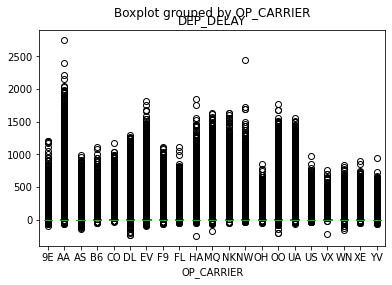

In [9]:
df.boxplot(by ='OP_CARRIER', column =['DEP_DELAY'], grid = False)

The data from 2009-2017 will be used for training whereas the data for 2018 will be used for testing. Firstly, the mean delay (in minutes) per day calculated. For simplicity, we are here dealing with data of only Southwest Airlines ('OP_CARRIER'='WN') as it does not have significant number of outliers

In [10]:
dfnew = df.groupby(['FL_DATE','OP_CARRIER']).mean().reset_index()
df2=dfnew[dfnew['OP_CARRIER']=='WN']
df2=df2[['DEP_DELAY','FL_DATE']]
df2['FL_DATE'] = pd.to_datetime(df2['FL_DATE'])
df2.set_index(['FL_DATE'], inplace=True)
df2

,DEP_DELAY
FL_DATE,
2009-01-01,5.950759
2009-01-02,13.607993
2009-01-03,14.120028
2009-01-04,21.233322
2009-01-05,20.033832
...,...
2017-12-27,23.585164
2017-12-28,16.141201
2017-12-29,18.553609


In [11]:
dftest = pd.read_csv('/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2018.csv', usecols=['FL_DATE', 'DEP_DELAY', 'OP_CARRIER'])
dftest = dftest.groupby(['FL_DATE','OP_CARRIER']).mean().reset_index()
dftest2=dftest[dftest['OP_CARRIER']=='WN']
dftest2=dftest2[['DEP_DELAY','FL_DATE']]
dftest2['FL_DATE'] = pd.to_datetime(dftest2['FL_DATE'])
dftest2.set_index(['FL_DATE'], inplace=True)
dftest2

,DEP_DELAY
FL_DATE,
2018-01-01,23.024846
2018-01-02,15.350932
2018-01-03,12.566578
2018-01-04,6.509660
2018-01-05,7.558038
...,...
2018-12-27,33.942715
2018-12-28,26.461115
2018-12-29,21.579760


In [12]:
from pandas.plotting import autocorrelation_plot

result = adfuller(df2.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.40825073113078
p-value: 1.9192154518350805e-08
Critial Values:
   1%, -3.432397734657946
Critial Values:
   5%, -2.862444764925196
Critial Values:
   10%, -2.567251626693097


As p-value<0.05 and ADF statistic<Critical Value, the time series is stationary 

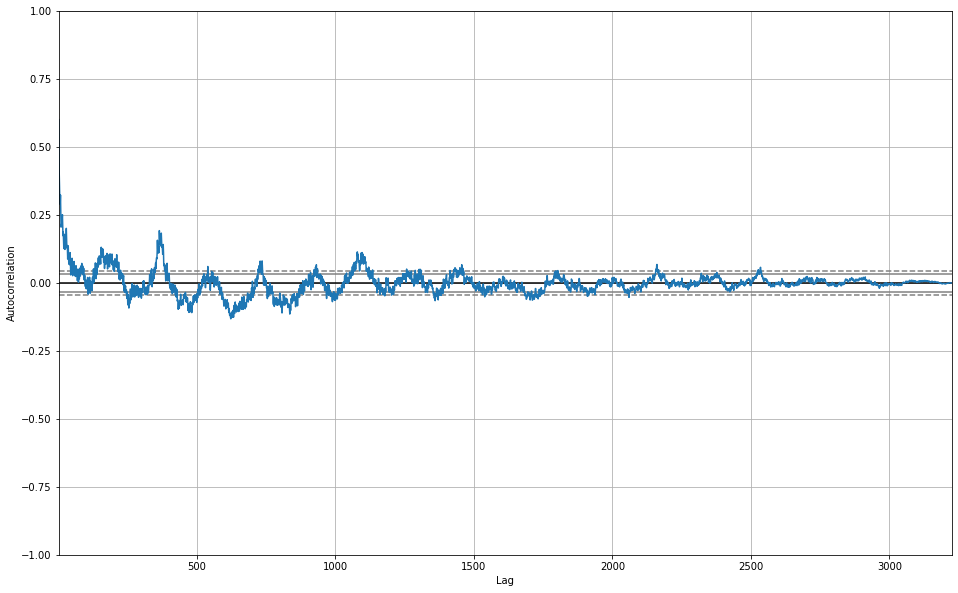

In [13]:
plt.figure(figsize=(16, 10))
autocorrelation_plot(df2)
plt.show()

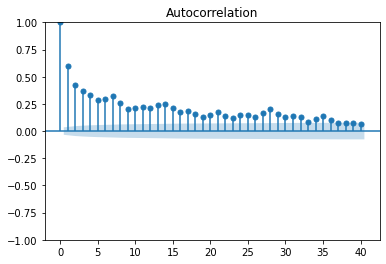

In [14]:
# ACF plot
plot_acf(df2, lags=40)
plt.show()

The ACF plot shows autocorrelation decaying towards zero and shows positive at lag 1

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


<Figure size 720x576 with 0 Axes>

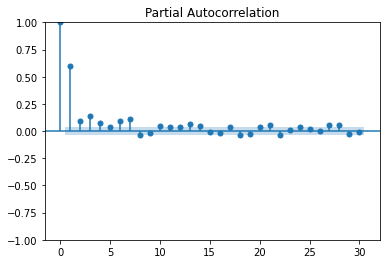

In [15]:
plt.figure(figsize=(10,8))
plot_pacf(df2, lags=30)
plt.show()

The PACF plot cuts off quickly towards zero which removes the necessity of the MA term. As it drops off at lag 5, we can use the AR(5) model. 

In [16]:
model = ARIMA(df2, order=(5,0,0))
model_fit = model.fit()
print(model_fit.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              DEP_DELAY   No. Observations:                 3225
Model:                 ARIMA(5, 0, 0)   Log Likelihood              -10195.693
Date:                Wed, 07 Sep 2022   AIC                          20405.385
Time:                        07:43:04   BIC                          20447.936
Sample:                             0   HQIC                         20420.634
                               - 3225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7558      0.449     23.946      0.000       9.875      11.636
ar.L1          0.5168      0.012     44.262      0.000       0.494       0.540
ar.L2          0.0187      0.016      1.161      0.2

<AxesSubplot:xlabel='FL_DATE'>

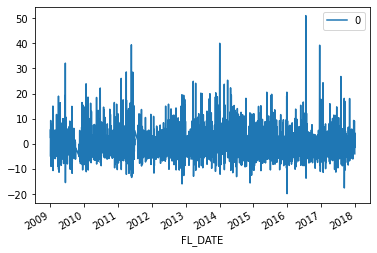

In [17]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

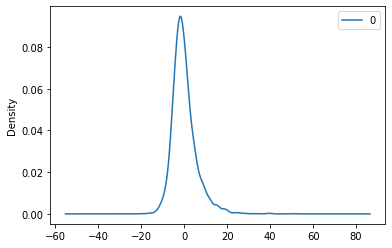

                 0
count  3225.000000
mean      0.002278
std       5.712387
min     -19.837561
25%      -3.470904
50%      -0.951828
75%       2.406370
max      51.034248


In [18]:
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

From the plot of residual errors it is evident that the mean in the residuals is near zero i.e. there is little-to-no bias in the prediction.

In [19]:
from sklearn.metrics import mean_squared_error

X = df2.values
Y = dftest2.values
size = int(len(X))
train, test = X, Y
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=13.886395, expected=23.024846
predicted=18.720917, expected=15.350932
predicted=14.464497, expected=12.566578
predicted=13.479780, expected=6.509660
predicted=9.796796, expected=7.558038
predicted=9.906917, expected=7.873999
predicted=9.076307, expected=9.931780
predicted=9.815006, expected=11.600225
predicted=10.572768, expected=15.824851
predicted=13.039471, expected=7.623217
predicted=9.164302, expected=11.481554
predicted=11.560606, expected=19.280854
predicted=15.179333, expected=5.843213
predicted=8.486200, expected=3.702826
predicted=7.757101, expected=11.331185
predicted=10.930317, expected=13.953726
predicted=11.801846, expected=12.998208
predicted=11.466913, expected=7.493529
predicted=9.183616, expected=6.831634
predicted=9.078180, expected=1.943593
predicted=6.063746, expected=8.973248
predicted=9.210352, expected=4.329581
predicted=6.233989, expected=2.297523
predicted=5.478561, expected=3.085699
predicted=5.594095, expected=2.676754
predicted=5.219865, expected=

Test data RMSE: 4.837


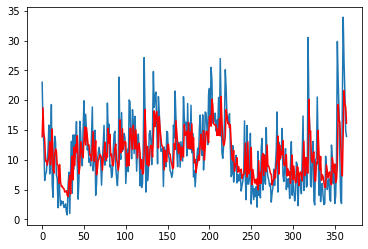

In [20]:
from math import sqrt
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test data RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [21]:
import numpy as np
print("Mean Absolute Percentage Error(MAPE): ",np.mean(np.abs((predictions - Y) / Y)) * 100)

Mean Absolute Percentage Error(MAPE):  77.97344027885215


In [22]:
from prophet import Prophet

df3=df.copy()
cols = ['FL_DATE', 'DEP_DELAY']
df3 = df3[cols]
df3

,FL_DATE,DEP_DELAY
0,2011-01-01,-7.0
1,2011-01-01,-8.0
2,2011-01-01,-2.0
3,2011-01-01,-4.0
4,2011-01-01,0.0
...,...,...
54343513,2016-12-31,-2.0
54343514,2016-12-31,81.0
54343515,2016-12-31,4.0
54343516,2016-12-31,7.0


In [23]:
df3 = df3.rename(columns={"FL_DATE":"ds", "DEP_DELAY":"y"})
df3['ds'] = pd.DatetimeIndex(df3['ds'])
df3 = df3.groupby(['ds']).mean().reset_index()
df3

,ds,y
0,2009-01-01,6.445018
1,2009-01-02,12.003146
2,2009-01-03,15.593855
3,2009-01-04,15.508241
4,2009-01-05,15.001774
...,...,...
3220,2017-12-27,17.328528
3221,2017-12-28,14.385933
3222,2017-12-29,15.888338
3223,2017-12-30,19.698089


In [24]:
prophet = Prophet()
prophet.fit(df3)

07:50:46 - cmdstanpy - INFO - Chain [1] start processing
07:50:47 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
future = prophet.make_future_dataframe(periods=30)
future.tail()

,ds
3250,2018-01-26
3251,2018-01-27
3252,2018-01-28
3253,2018-01-29
3254,2018-01-30


In [26]:
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3250,2018-01-26,8.121740,1.191645,14.501660
3251,2018-01-27,5.221733,-0.780865,11.733013
3252,2018-01-28,6.843863,0.272442,13.664398
3253,2018-01-29,7.887117,1.025893,14.506603
3254,2018-01-30,5.990945,-0.623776,12.156288


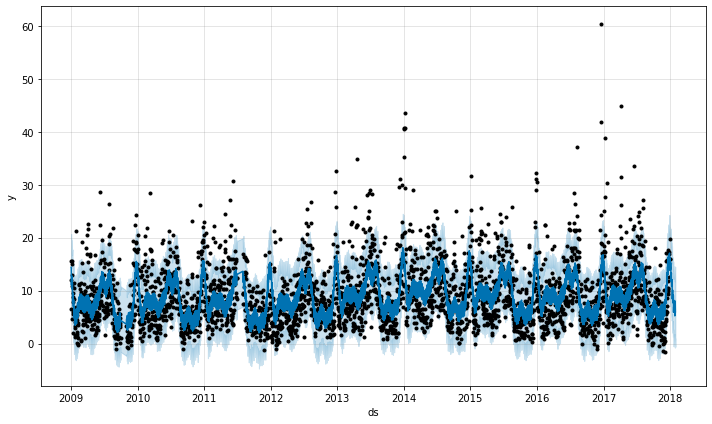

In [27]:
prophet.plot(forecast)
plt.show()

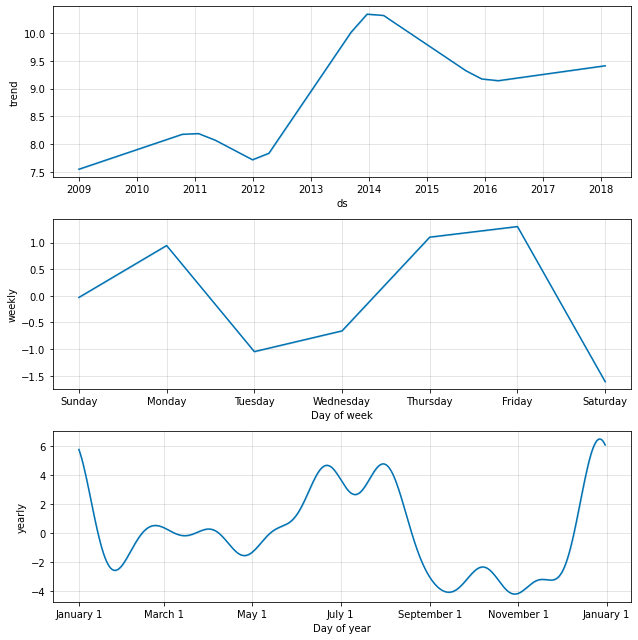

In [28]:
prophet.plot_components(forecast)
plt.show()